In [2]:
import requests
import json
import prettytable
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.genmod.families as families
from statsmodels.genmod.families import Gamma, Tweedie
from statsmodels.genmod.families.links import Log 
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.regressionplots import abline_plot
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore", message="Negative binomial dispersion parameter alpha not set")

In [3]:
# Variable Descriptors
#  AWU - Average Weeks Unemployed
#  CLF - Civilian Labor Force 
#  EPR - Employment Population Ratio
#  LFPR - Civilian Labor Force Participation Rate
#  TNE - Total Nonfarm Employment
#  U3 - U-3 Unemployment Rates
#  UA - U.S. city average, All Items
#  UFH - U.S. city average, Food at home
#  UG - U.S. city average, Gasoline
#  USH - U.S. city average, Housing
#  USM - U.S. city average, Medical Care
#  UST - U.S. city average, Transportation

In [4]:
# Create 2 Separate Dataframes
all_df = pd.read_csv('data.csv')

scaler = StandardScaler()
all_df[['AWU', 'CLF', 'EPR', 'LFPR', 'TNE', 'UA', 'UFH', 'UG', 'USH', 'USM', 'UST']] = scaler.fit_transform(all_df[['AWU', 'CLF', 'EPR', 'LFPR', 'TNE', 'UA', 'UFH', 'UG', 'USH', 'USM', 'UST']])

all_df['U3_lag1'] = all_df['U3'].shift(1)

last_10 = all_df.copy()
last_10.drop(all_df.head(468).index, inplace=True)  
print(last_10)

post_covid = all_df.copy()
post_covid.drop(all_df.head(563).index, inplace=True) 
print(post_covid)

         Date       AWU       CLF       EPR      LFPR       TNE   U3  \
468  1/1/2014  2.160599  0.874026 -0.850186 -0.977351  0.758894  6.6   
469  2/1/2014  2.352891  0.880217 -0.895339 -0.977351  0.766067  6.7   
470  3/1/2014  2.188070  0.905976 -0.805033 -0.866613  0.778563  6.7   
471  4/1/2014  2.133129  0.874829 -0.805033 -1.032720  0.792593  6.2   
472  5/1/2014  2.064454  0.889717 -0.805033 -0.977351  0.801705  6.3   
..        ...       ...       ...       ...       ...       ...  ...   
592  5/1/2024  0.251419  1.459158 -0.263201 -1.198827  1.700777  4.0   
593  6/1/2024  0.182744  1.472250 -0.263201 -1.143458  1.706100  4.1   
594  7/1/2024  0.169009  1.492101 -0.308354 -1.088089  1.712596  4.3   
595  8/1/2024  0.223949  1.497773 -0.308354 -1.088089  1.716115  4.2   
596  9/1/2024  0.443711  1.504863 -0.218049 -1.088089  1.726175  4.1   

           UA       UFH        UG       USH       USM       UST  U3_lag1  
468  0.922490  1.010521  1.482616  0.820741  0.986955  1.084

In [8]:
# Initial VIF on last_10
X_10 = last_10[['AWU', 'CLF', 'EPR', 'LFPR', 'TNE', 'UA', 'UFH', 'UG', 'USH', 'USM', 'UST', 'U3_lag1']].values  
y_10 = last_10['U3'].values 

X_10 = sm.add_constant(X_10) 

vif_data = pd.DataFrame()
vif_data["Feature"] = ['const'] + ['AWU', 'CLF', 'EPR', 'LFPR', 'TNE', 'UA', 'UFH', 'UG', 'USH', 'USM', 'UST', 'U3_lag1']
vif_data["VIF"] = [variance_inflation_factor(X_10, i) for i in range(X_10.shape[1])]

print(vif_data)

    Feature           VIF
0     const   6442.228721
1       AWU     10.920623
2       CLF    187.873550
3       EPR    111.768879
4      LFPR     21.738504
5       TNE    241.717116
6        UA  14851.579783
7       UFH    352.364589
8        UG     58.060532
9       USH   5242.214097
10      USM    157.936402
11      UST   1077.509226
12  U3_lag1      4.784716


In [10]:
# Final VIF checking on last_10
X_10 = last_10[['AWU', 'LFPR', 'UFH', 'UG', 'U3_lag1']].values  
y_10 = last_10['U3'].values 

X_10 = sm.add_constant(X_10) 

vif_data = pd.DataFrame()
vif_data["Feature"] = ['const'] + ['AWU', 'LFPR', 'UFH', 'UG', 'U3_lag1']
vif_data["VIF"] = [variance_inflation_factor(X_10, i) for i in range(X_10.shape[1])]

print(vif_data)

   Feature        VIF
0    const  42.437285
1      AWU   1.567544
2     LFPR   1.733915
3      UFH   3.183683
4       UG   2.552061
5  U3_lag1   1.789356


In [12]:
# Initial VIF on post_covid
X_covid = post_covid[['AWU', 'CLF', 'EPR', 'LFPR', 'TNE', 'UA', 'UFH', 'UG', 'USH', 'USM', 'UST', 'U3_lag1']].values  
y_covid = post_covid['U3'].values 

X_covid = sm.add_constant(X_covid) 

vif_data = pd.DataFrame()
vif_data["Feature"] = ['const'] + ['AWU', 'CLF', 'EPR', 'LFPR', 'TNE', 'UA', 'UFH', 'UG', 'USH', 'USM', 'UST', 'U3_lag1']
vif_data["VIF"] = [variance_inflation_factor(X_covid, i) for i in range(X_covid.shape[1])]

print(vif_data)

    Feature           VIF
0     const  51939.041962
1       AWU      8.412612
2       CLF    204.550789
3       EPR     10.309797
4      LFPR     42.530487
5       TNE    707.328149
6        UA   4362.896767
7       UFH    104.092213
8        UG     49.032326
9       USH   3489.729313
10      USM     18.809180
11      UST    142.290022
12  U3_lag1      6.130371


In [14]:
# Final VIF on post_covid
X_covid = post_covid[['EPR', 'UG', 'USM', 'U3_lag1']].values  
y_covid = post_covid['U3'].values 

X_covid = sm.add_constant(X_covid) 

vif_data = pd.DataFrame()
vif_data["Feature"] = ['const'] + ['EPR', 'UG', 'USM', 'U3_lag1']
vif_data["VIF"] = [variance_inflation_factor(X_covid, i) for i in range(X_covid.shape[1])]

print(vif_data)

   Feature          VIF
0    const  1380.842580
1      EPR     1.508538
2       UG     1.174112
3      USM     1.363814
4  U3_lag1     1.510075


In [16]:
# Train-test Splits
X_train_10, X_test_10, y_train_10, y_test_10 = train_test_split(X_10, y_10, test_size=0.2, random_state=42)

X_train_covid, X_test_covid, y_train_covid, y_test_covid = train_test_split(X_covid, y_covid, test_size=0.2, random_state=42)

In [18]:
# Linear Regression for last_10 dataset
linear_model_10 = sm.OLS(y_train_10, X_train_10).fit()
y_pred_lr_10 = linear_model_10.predict(X_test_10)
mse_lr_10 = mean_squared_error(y_test_10, y_pred_lr_10)
aic_lr_10 = linear_model_10.aic

# Linear Regression for post_covid dataset
linear_model_covid = sm.OLS(y_train_covid, X_train_covid).fit()
y_pred_lr_covid = linear_model_covid.predict(X_test_covid)
mse_lr_covid = mean_squared_error(y_test_covid, y_pred_lr_covid)
aic_lr_covid = linear_model_covid.aic

In [20]:
# Poisson Regression for last_10 dataset
poisson_model_10 = sm.GLM(y_train_10, X_train_10, family=families.Poisson(link=Log())).fit()
y_pred_poisson_10 = poisson_model_10.predict(X_test_10)
mse_poisson_10 = mean_squared_error(y_test_10, y_pred_poisson_10)
aic_poisson_10 = poisson_model_10.aic

# Poisson Regression for post_covid dataset
poisson_model_covid = sm.GLM(y_train_covid, X_train_covid, family=families.Poisson(link=Log())).fit()
y_pred_poisson_covid = poisson_model_covid.predict(X_test_covid)
mse_poisson_covid = mean_squared_error(y_test_covid, y_pred_poisson_covid)
aic_poisson_covid = poisson_model_covid.aic

In [22]:
# Negative Binomial Regression for last_10 dataset
nb_model_10 = sm.GLM(y_train_10, X_train_10, family=families.NegativeBinomial(link=Log())).fit()
y_pred_nb_10 = nb_model_10.predict(X_test_10)
mse_nb_10 = mean_squared_error(y_test_10, y_pred_nb_10)
aic_nb_10 = nb_model_10.aic

# Negative Binomial Regression for post_covid dataset
nb_model_covid = sm.GLM(y_train_covid, X_train_covid, family=families.NegativeBinomial(link=Log())).fit()
y_pred_nb_covid = nb_model_covid.predict(X_test_covid)
mse_nb_covid = mean_squared_error(y_test_covid, y_pred_nb_covid)
aic_nb_covid = nb_model_covid.aic

In [23]:
# Gamma Regression for last_10 dataset
gamma_model_10 = sm.GLM(y_train_10, X_train_10, family=Gamma(link=Log())).fit()
y_pred_gamma_10 = gamma_model_10.predict(X_test_10)
mse_gamma_10 = mean_squared_error(y_test_10, y_pred_gamma_10)
aic_gamma_10 = gamma_model_10.aic

# Gamma Regression for post_covid dataset
gamma_model_covid = sm.GLM(y_train_covid, X_train_covid, family=Gamma(link=Log())).fit()
y_pred_gamma_covid = gamma_model_covid.predict(X_test_covid)
mse_gamma_covid = mean_squared_error(y_test_covid, y_pred_gamma_covid)
aic_gamma_covid = gamma_model_covid.aic

In [26]:
# Tweedie Regression for last_10 dataset
tweedie_model_10 = sm.GLM(y_train_10, X_train_10, family=Tweedie(link=Log())).fit()
y_pred_tweedie_10 = tweedie_model_10.predict(X_test_10)
mse_tweedie_10 = mean_squared_error(y_test_10, y_pred_tweedie_10)
aic_tweedie_10 = tweedie_model_10.aic

# Tweedie Regression for post_covid dataset
tweedie_model_covid = sm.GLM(y_train_covid, X_train_covid, family=Tweedie(link=Log())).fit()
y_pred_tweedie_covid = tweedie_model_covid.predict(X_test_covid)
mse_tweedie_covid = mean_squared_error(y_test_covid, y_pred_tweedie_covid)
aic_tweedie_covid = tweedie_model_covid.aic

In [27]:
# Find best model for last_10 dataset
results_10 = {
    'Model': ['Linear Regression', 'Poisson Regression', 'Negative Binomial Regression', 'Gamma Regression', 'Tweedie Regression'],
    'AIC': [aic_lr_10, aic_poisson_10, aic_nb_10, aic_gamma_10, aic_tweedie_10],
    'MSE': [mse_lr_10, mse_poisson_10, mse_nb_10, mse_gamma_10, mse_tweedie_10]
}

results_df_10 = pd.DataFrame(results_10)

best_aic_model_10 = results_df_10.loc[results_df_10['AIC'].idxmin()]
best_mse_model_10 = results_df_10.loc[results_df_10['MSE'].idxmin()]

print("Best Model by AIC for last_10:", best_aic_model_10)
print("Best Model by MSE for last_10:", best_mse_model_10)

Best Model by AIC for last_10: Model    Gamma Regression
AIC            187.387746
MSE              0.294095
Name: 3, dtype: object
Best Model by MSE for last_10: Model    Gamma Regression
AIC            187.387746
MSE              0.294095
Name: 3, dtype: object


In [34]:
# Find best model for post_covid dataset
results_covid = {
    'Model': ['Linear Regression', 'Poisson Regression', 'Negative Binomial Regression', 'Gamma Regression', 'Tweedie Regression'],
    'AIC': [aic_lr_covid, aic_poisson_covid, aic_nb_covid, aic_gamma_covid, aic_tweedie_covid],
    'MSE': [mse_lr_covid, mse_poisson_covid, mse_nb_covid, mse_gamma_covid, mse_tweedie_covid]
}

results_df_covid = pd.DataFrame(results_covid)

print("Models and their metrics for post_covid dataset:")
print(results_df_covid)


Models and their metrics for post_covid dataset:
                          Model           AIC       MSE
0             Linear Regression    -26.399518  0.007480
1            Poisson Regression     96.554949  0.007571
2  Negative Binomial Regression    141.924069  0.007731
3              Gamma Regression    -25.592360  0.007774
4            Tweedie Regression  17379.900612  0.007571


In [30]:
# Find best model for post_covid dataset
results_covid = {
    'Model': ['Linear Regression', 'Poisson Regression', 'Negative Binomial Regression', 'Gamma Regression', 'Tweedie Regression'],
    'AIC': [aic_lr_covidm aic_poisson_covid, aic_nb_covid, aic_gamma_covid, aic_tweedie_covid],
    'MSE': [mse_lr_covid, mse_poisson_covid, mse_nb_covid, mse_gamma_covid, mse_tweedie_covid]
}

results_df_covid = pd.DataFrame(results_covid)

best_aic_model_covid = results_df_covid.loc[results_df_covid['AIC'].idxmin()]
best_mse_model_covid = results_df_covid.loc[results_df_covid['MSE'].idxmin()]

print("Best Model by AIC for post_covid:", best_aic_model_covid)
print("Best Model by MSE for post_covid:", best_mse_model_covid)

Best Model by AIC for post_covid: Model    Gamma Regression
AIC             -25.59236
MSE              0.007774
Name: 2, dtype: object
Best Model by MSE for post_covid: Model    Tweedie Regression
AIC            17379.900612
MSE                0.007571
Name: 3, dtype: object


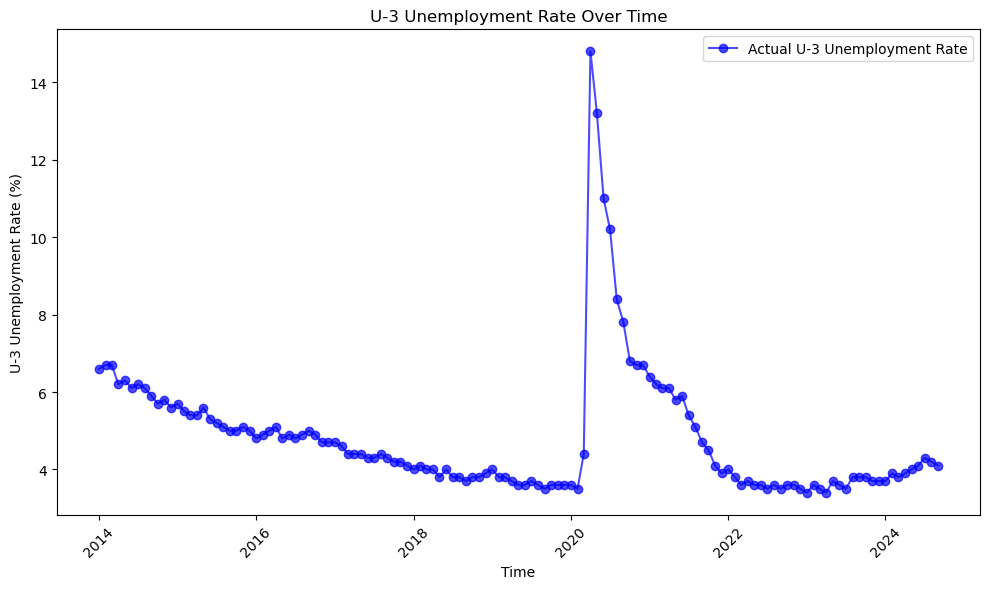

In [32]:
# Convert 'Date' column to datetime format and set as index
last_10['Date'] = pd.to_datetime(last_10['Date'])
last_10.set_index('Date', inplace=True)

# Plot the U-3 unemployment rate over time
plt.figure(figsize=(10, 6))
plt.plot(last_10.index, last_10['U3'], color='blue', marker='o', linestyle='-', alpha=0.7, label='Actual U-3 Unemployment Rate')
plt.xlabel('Time')
plt.ylabel('U-3 Unemployment Rate (%)')
plt.title('U-3 Unemployment Rate Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()  
plt.show()

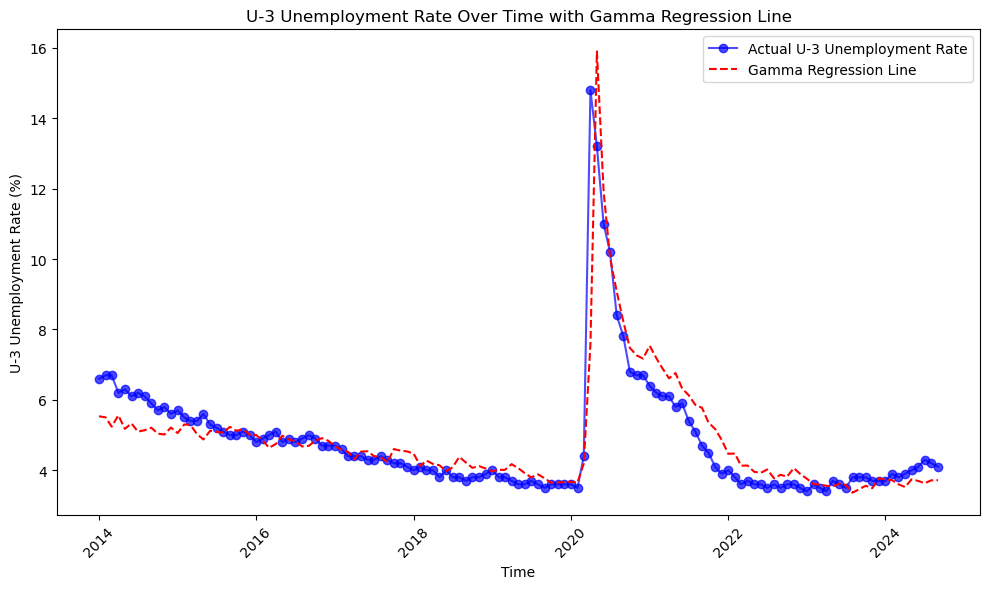

In [217]:
# Add a constant to the predictors for the Gamma model
X_covid_full = sm.add_constant(last_10[['AWU', 'LFPR', 'UFH', 'UG', 'U3_lag1']].values) 
y_pred_gamma_full = gamma_model_10.predict(X_covid_full)

# Plot the actual U-3 unemployment rate and the Gamma regression line
plt.figure(figsize=(10, 6))
plt.plot(last_10.index, last_10['U3'], color='blue', marker='o', linestyle='-', alpha=0.7, label='Actual U-3 Unemployment Rate')
plt.plot(last_10.index, y_pred_gamma_full, color='red', linestyle='--', label='Gamma Regression Line')
plt.xlabel('Time')
plt.ylabel('U-3 Unemployment Rate (%)')
plt.title('U-3 Unemployment Rate Over Time with Gamma Regression Line')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to prevent label clipping
plt.show()

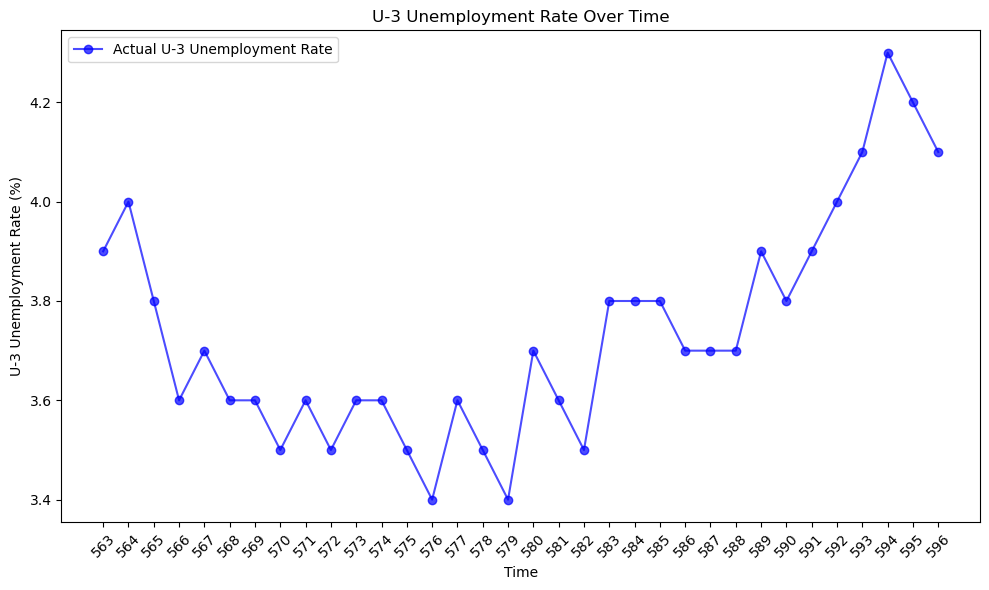

In [23]:
# Scatter plot of unemployment rate (U-3) vs. time
plt.figure(figsize=(10, 6))
plt.plot(post_covid.index, post_covid['U3'], color='blue', marker='o', linestyle='-', alpha=0.7, label='Actual U-3 Unemployment Rate')

# Labeling the axes and the plot
plt.xlabel('Time')
plt.ylabel('U-3 Unemployment Rate (%)')
plt.title('U-3 Unemployment Rate Over Time')

# Set x-axis to label every month
plt.xticks(post_covid.index, rotation=45)

# Add legend and adjust layout
plt.legend()
plt.tight_layout()  # Adjust layout to prevent label clipping
plt.show()

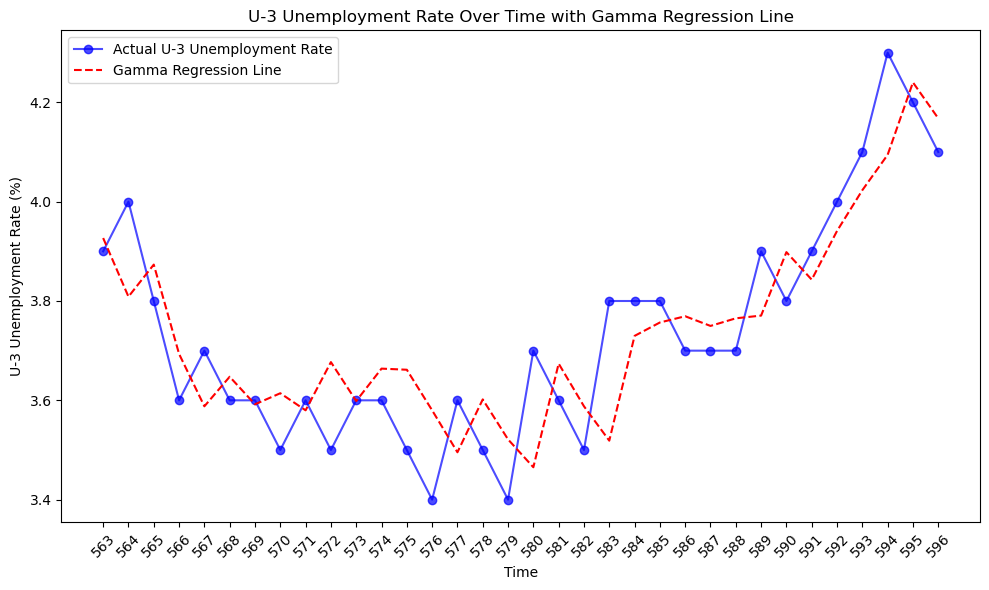

In [24]:
# Plot the Gamma Regression line ontop of the Unemployment Rate
X_covid_full = sm.add_constant(post_covid[['EPR', 'UG', 'USM', 'U3_lag1']].values) 
y_pred_gamma_full = linear_model_covid.predict(X_covid_full)

plt.figure(figsize=(10, 6))
plt.plot(post_covid.index, post_covid['U3'], color='blue', marker='o', linestyle='-', alpha=0.7, label='Actual U-3 Unemployment Rate')
plt.plot(post_covid.index, y_pred_gamma_full, color='red', linestyle='--', label='Gamma Regression Line')
plt.xlabel('Time')
plt.ylabel('U-3 Unemployment Rate (%)')
plt.title('U-3 Unemployment Rate Over Time with Gamma Regression Line')
plt.xticks(post_covid.index, rotation=45)
plt.legend()
plt.tight_layout()  
plt.show()